In [1]:
import os
import rosbag
import rospy
import tf
import numpy as np
import tf2_ros
import tf2_geometry_msgs


data_already_loaded = False

bag_dir_diff = '../../../dissertation_data/diff_2'
bag_dir_omni = '../../../dissertation_data/omni'

# List all .bag files in the directory
bag_files_diff = sorted([f for f in os.listdir(bag_dir_diff) if f.endswith('.bag')])
bag_files_omni = sorted([f for f in os.listdir(bag_dir_omni) if f.endswith('.bag')])

bag_file_diff_full = [bag_dir_diff + '/' + bag_file for bag_file in bag_files_diff]
bag_file_omni_full = [bag_dir_omni + '/' + bag_file for bag_file in bag_files_omni]

print('Diff:')
for bag_file in bag_file_diff_full:
    print(bag_file)

print('Omni:')
for bag_file in bag_file_omni_full:
    print(bag_file)

Diff:
../../../dissertation_data/diff_2/a_first_perfect.bag
../../../dissertation_data/diff_2/a_first_perfect.orig.bag
../../../dissertation_data/diff_2/a_first_perfect.orig_filtered.bag
../../../dissertation_data/diff_2/b_second_perfect.bag
../../../dissertation_data/diff_2/c_third_scrach.bag
../../../dissertation_data/diff_2/d_forth.bag
../../../dissertation_data/diff_2/e_fifth.bag
Omni:
../../../dissertation_data/omni/a_first_perfect.bag
../../../dissertation_data/omni/b_second_perfect.bag
../../../dissertation_data/omni/c_third_perfect.bag
../../../dissertation_data/omni/d_forth_perfect.bag
../../../dissertation_data/omni/e_fifth_little_scratch_end.bag


In [2]:
chosen_bag = bag_file_diff_full[0]

# Times that took to finish each experiment

In [3]:
if not data_already_loaded:
    rospy.init_node('tf_buffer_node', anonymous=True)
    cache_time = rospy.Duration(172800) #Two days
    tf_buffer = tf2_ros.Buffer(cache_time=cache_time)

    # Omni bags
    bag = rosbag.Bag(chosen_bag, 'r')
    for topic, msg, t in bag.read_messages(topics=['/tf', '/tf_static', '/vrpn_client_node/L1/pose']):

        if topic == '/tf_static':
            for transform in msg.transforms:
                tf_buffer.set_transform(transform, 'default_authority')

        if topic == '/tf':
            for transform in msg.transforms:
                tf_buffer.set_transform(transform, 'default_authority')

    bag.close()

# 3m 28

/tmp/ipykernel_74695/3305264192.py:16: UserWarning: translation should be of type Vector3
  tf_buffer.set_transform(transform, 'default_authority')
/tmp/ipykernel_74695/3305264192.py:16: UserWarning: rotation should be of type Quaternion
  tf_buffer.set_transform(transform, 'default_authority')
/tmp/ipykernel_74695/3305264192.py:12: UserWarning: translation should be of type Vector3
  tf_buffer.set_transform(transform, 'default_authority')
/tmp/ipykernel_74695/3305264192.py:12: UserWarning: rotation should be of type Quaternion
  tf_buffer.set_transform(transform, 'default_authority')


In [4]:
if not data_already_loaded:

    bag = rosbag.Bag(chosen_bag, 'r')
    poses = []
    base_points = []
    filtered_closest_points = []
    matched_base_points = []
    lidar = []
    local_map = []
    local_path = []
    smoothed_local_path = []

    for topic, msg, t in bag.read_messages(topics=['/vrpn_client_node/L1/pose', '/base_points', '/rplidar/scan', '/map', '/local_map', '/local_path', '/smoothed_local_path', '/closest_points', '/filtered_closest_points', '/matched_base_points']):
        
        if topic == '/base_points':
            base_points.append(msg)

        if topic == '/filtered_closest_points':
            filtered_closest_points.append(msg)
        
        if topic == '/matched_base_points':
            matched_base_points.append(msg)
        
        if topic == '/rplidar/scan':
            lidar.append(msg)
        
        if topic == '/map':
            map_msg = msg
        
        if topic == '/local_map':
            local_map.append(msg)
        
        if topic == '/local_path':
            local_path.append(msg)
        
        if topic == '/smoothed_local_path':
            smoothed_local_path.append(msg)
        
        if topic == '/vrpn_client_node/L1/pose':
            poses.append(msg)

    bag.close()

## Corrigindo ponto central no diferencial

In [6]:
import tf
from geometry_msgs.msg import PoseStamped

new_poses = []
yaw = []

for pose in poses:
    x = pose.pose.position.x
    y = pose.pose.position.y

    orientation_q = pose.pose.orientation
    orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
    _, _, yaw_ = tf.transformations.euler_from_quaternion(orientation_list)
    yaw.append(yaw_)
    
    new_x = x - 0.065 * np.cos(yaw_)
    new_y = y - 0.065 * np.sin(yaw_)
    
    new_pose = PoseStamped()
    new_pose.header = pose.header
    new_pose.pose.position.x = new_x
    new_pose.pose.position.y = new_y
    new_pose.pose.position.z = pose.pose.position.z
    new_pose.pose.orientation = pose.pose.orientation

    new_poses.append(new_pose)

yaw = np.array(yaw)

In [7]:
from PIL import Image

# Function to get the dominant color in an image
def get_dominant_color(image_path):
    image = Image.open(image_path)
    image = image.resize((1, 1))  # Resize the image to 1x1 to get the dominant color
    dominant_color = image.getpixel((0, 0))  # Get the RGB value of the pixel
    return '#{:02x}{:02x}{:02x}'.format(*dominant_color)

# Path to the images
image1_path = 'light_gray.png' 
image2_path = 'dark_green.png'

# Get the dominant colors
color1_hex = get_dominant_color(image1_path)
color2_hex = get_dominant_color(image2_path)

# Print the results
print(f"Light gray color (free space): {color1_hex}")
print(f"Dark gray color (unknown space): {color2_hex}")

Light gray color (free space): #808080
Dark gray color (unknown space): #384443


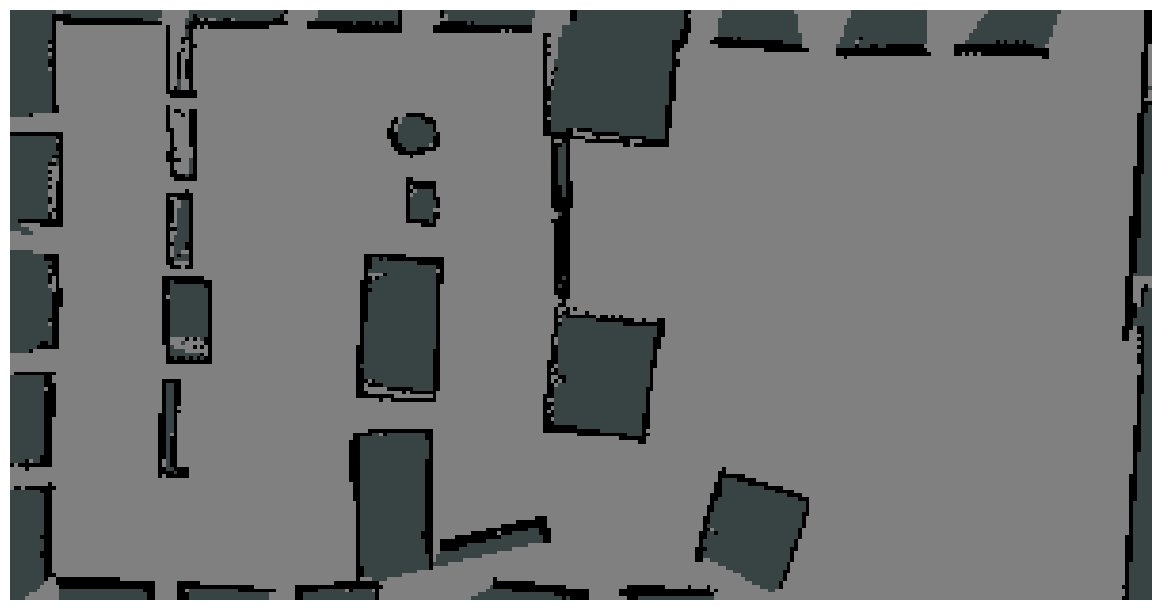

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Map metadata
resolution = map_msg.info.resolution 
origin_x = map_msg.info.origin.position.x
origin_y = map_msg.info.origin.position.y
width = map_msg.info.width
height = map_msg.info.height

map_data = np.array(map_msg.data).reshape((height, width))
cmap = ListedColormap([color1_hex, '#000000', color2_hex]) 

map_data_visual = np.copy(map_data)
map_data_visual[map_data == -1] = 2
map_data_visual[map_data == 0] = 0 
map_data_visual[map_data > 0] = 1   

# new_positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in new_diff_go_poses[0]])

x_limits = [-2, 4]
y_limits = [-1.6, 1.5]

x_range = x_limits[1] - x_limits[0]
y_range = y_limits[1] - y_limits[0]
aspect_ratio = x_range / y_range

fig_width = 12  
fig_height = fig_width / aspect_ratio

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
extent = [origin_x, origin_x + width * resolution, origin_y, origin_y + height * resolution]
ax.imshow(map_data_visual, cmap=cmap, origin='lower', extent=extent)

ax.set_xlim(x_limits)
ax.set_ylim(y_limits)

circle_1 = plt.Circle((-1.45, -1.2), 0.1, color='red', fill=True)
circle_2 = plt.Circle((1.55, -0.8), 0.1, color='red', fill=True)

# cut_position_1 = np.array([-1.45, -1.2])
# cut_position_2 = np.array([1.55, -0.8])

# ax.add_patch(circle_1)
# ax.add_patch(circle_2)

plt.axis('off')

plt.tight_layout()
fig.savefig('map.png', dpi=300)
plt.show()

In [9]:
import copy
import laser_geometry
import tf2_ros
import tf2_sensor_msgs

def transform_laser_scans_to_world_frame(filtered_lidar_scans, tf_buffer, target_frame='world', max_range=6.0):

    projector = laser_geometry.LaserProjection()
    lidar_world_frame = []

    for original_msg in filtered_lidar_scans:
        try:
            msg = copy.deepcopy(original_msg)
            transform = tf_buffer.lookup_transform(target_frame, msg.header.frame_id, msg.header.stamp)
            msg.ranges = [r if r <= max_range else float('inf') for r in msg.ranges]
            cloud = projector.projectLaser(msg)
            transformed_cloud = tf2_sensor_msgs.do_transform_cloud(cloud, transform)
            lidar_world_frame.append(transformed_cloud)

        except tf2_ros.LookupException as e:
            print(f"LookupException: {e}")
        except tf2_ros.ExtrapolationException as e:
            print(f"ExtrapolationException: {e}")
        except Exception as e:
            print(f"Transformation failed at time {msg.header.stamp.to_sec()}: {e}")

    return np.array(lidar_world_frame)

In [10]:
import copy
import tf2_ros
import tf2_geometry_msgs
import numpy as np
from sensor_msgs.msg import PointCloud
from geometry_msgs.msg import Point32

def transform_pointcloud_to_world_frame(filtered_pointclouds, tf_buffer, target_frame='world'):
    pointcloud_world_frame = []

    for original_msg in filtered_pointclouds:
        try:
            msg = copy.deepcopy(original_msg)

            transform = tf_buffer.lookup_transform(target_frame, msg.header.frame_id, msg.header.stamp)

            transformed_points = []
            for point in msg.points:
                point_stamped = tf2_geometry_msgs.PointStamped()
                point_stamped.header = msg.header
                point_stamped.point.x = point.x
                point_stamped.point.y = point.y
                point_stamped.point.z = point.z

                transformed_point = tf2_geometry_msgs.do_transform_point(point_stamped, transform)

                transformed_points.append((transformed_point.point.x,
                                           transformed_point.point.y,
                                           transformed_point.point.z))

            pointcloud_array = np.array(transformed_points, dtype=np.float32)
            pointcloud_world_frame.append(pointcloud_array)

        except tf2_ros.LookupException as e:
            print(f"LookupException: {e}")
        except tf2_ros.ExtrapolationException as e:
            print(f"ExtrapolationException: {e}")
        except Exception as e:
            print(f"Transformation failed at time {msg.header.stamp.to_sec()}: {e}")

    return np.array(pointcloud_world_frame)

In [15]:
laser_world = transform_laser_scans_to_world_frame(lidar, tf_buffer)

ExtrapolationException: Lookup would require extrapolation 4.881861210s into the past.  Requested time 1726753409.960962057 but the earliest data is at time 1726753414.842823267, when looking up transform from frame [laser] to frame [world]
ExtrapolationException: Lookup would require extrapolation 4.808454275s into the past.  Requested time 1726753410.034368992 but the earliest data is at time 1726753414.842823267, when looking up transform from frame [laser] to frame [world]
ExtrapolationException: Lookup would require extrapolation 4.728586912s into the past.  Requested time 1726753410.114236355 but the earliest data is at time 1726753414.842823267, when looking up transform from frame [laser] to frame [world]
ExtrapolationException: Lookup would require extrapolation 4.648465872s into the past.  Requested time 1726753410.194357395 but the earliest data is at time 1726753414.842823267, when looking up transform from frame [laser] to frame [world]
ExtrapolationException: Lookup would

In [21]:
len(laser_world)

1393

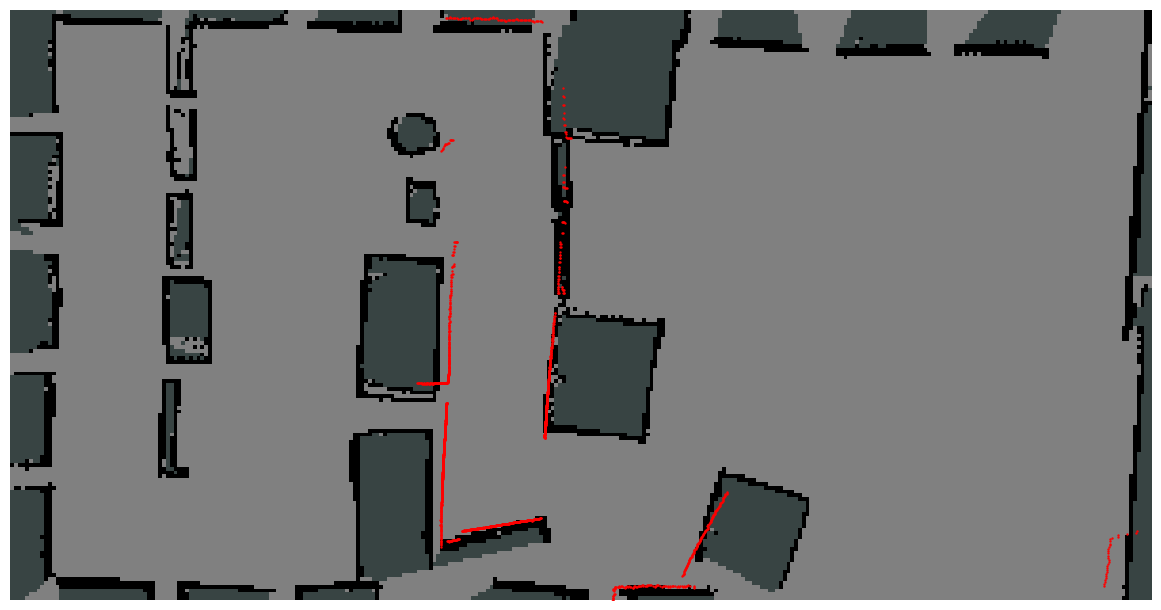

In [25]:
import sensor_msgs.point_cloud2 as pc2

points = list(pc2.read_points(laser_world[817], field_names=("x", "y", "z"), skip_nans=True))
points_array = np.array(points)

x_limits = [-2, 4]
y_limits = [-1.6, 1.5]

x_range = x_limits[1] - x_limits[0]
y_range = y_limits[1] - y_limits[0]
aspect_ratio = x_range / y_range

fig_width = 12  
fig_height = fig_width / aspect_ratio

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
extent = [origin_x, origin_x + width * resolution, origin_y, origin_y + height * resolution]
ax.imshow(map_data_visual, cmap=cmap, origin='lower', extent=extent)

ax.set_xlim(x_limits)
ax.set_ylim(y_limits)

plt.axis('off')
plt.scatter(points_array[:, 0], points_array[:, 1], c='red', s=0.5)

plt.tight_layout()
# fig.savefig('map.png', dpi=300)
plt.show()

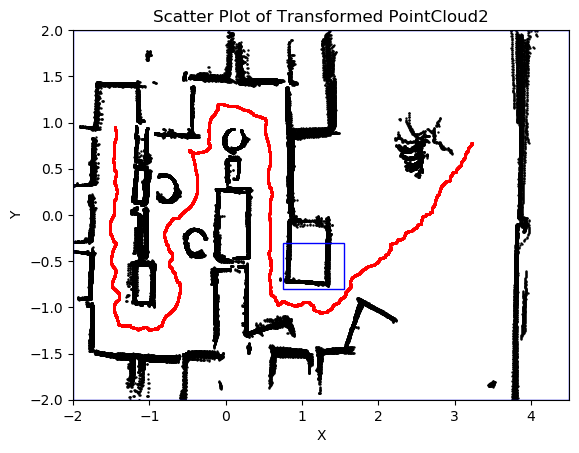

In [14]:
import sensor_msgs.point_cloud2 as pc2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

wich_experiment = 1

lidar_points = []

for transformed_cloud in laser_omni_go_filtered_world[wich_experiment - 1]:
    # Read the points from the PointCloud2 message
    points = list(pc2.read_points(transformed_cloud, field_names=("x", "y", "z"), skip_nans=True))

    # Filter points with x values greater than 2
    # Filter points with x values between -2 and 2 and y values between -2 and 2
    points = [point for point in points if -2 <= point[0] <= 4.5 and -2 <= point[1] <= 2]

    # Convert to numpy array for easier manipulation
    points_array = np.array(points)

    lidar_points.extend(points_array)

# Scatter plot the points
lidar_points = np.array(lidar_points)

plt.scatter(lidar_points[:, 0], lidar_points[:, 1], c='black', s=0.5)

positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in poses_omni_go[wich_experiment - 1]])
plt.scatter(positions[:, 0], positions[:, 1], label=f'omni Position {i}', s=1, c='red')

# Draw a rectangle
rect = plt.Rectangle((-2, -2), 6.5, 4, linewidth=1, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)

rect = plt.Rectangle((0.75, -0.8), 0.8, 0.5, linewidth=1, edgecolor='blue', facecolor='none')
plt.gca().add_patch(rect)

plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(-2, 2)
plt.xlim(-2, 4.5)
plt.title('Scatter Plot of Transformed PointCloud2')
# plt.axis('equal')
plt.show()